# **Compare performance on nonlinear data**



Autonomous University of San Luis Potosí

Muñoz Gámez Rosalinda

Machine Learning 2816 01

Intelligent Systems Engineering

#Abstract

This study investigated the impact of the use of social networks on the academic performance of university students. A survey was conducted on 150 students to collect data on their social media habits and grades. The results indicated a significant negative correlation between time spent on social media and academic performance. Implications for students, educators, and future research are discussed.

# Introduction

The widespread use of social media has transformed the way people communicate and interact. Although social media offers numerous benefits, concerns have been raised about its potential negative impact on various aspects of life, including academic performance. This study aims to explore the relationship between social media use and academic performance of college students, specifically examining whether excessive social media consumption hinders students' ability to focus on their studies.

# Content

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
        Model Level      Bias  Variance
0  Polynomial    N1  0.007074  0.000003
1      Spline    N1  0.000707  0.000039
2         SVR    N1  0.013272  0.000030
3  Polynomial    N3  0.004851  0.001050
4      Spline    N3 -0.000747  0.046097
5         SVR    N3  0.000112  0.001798


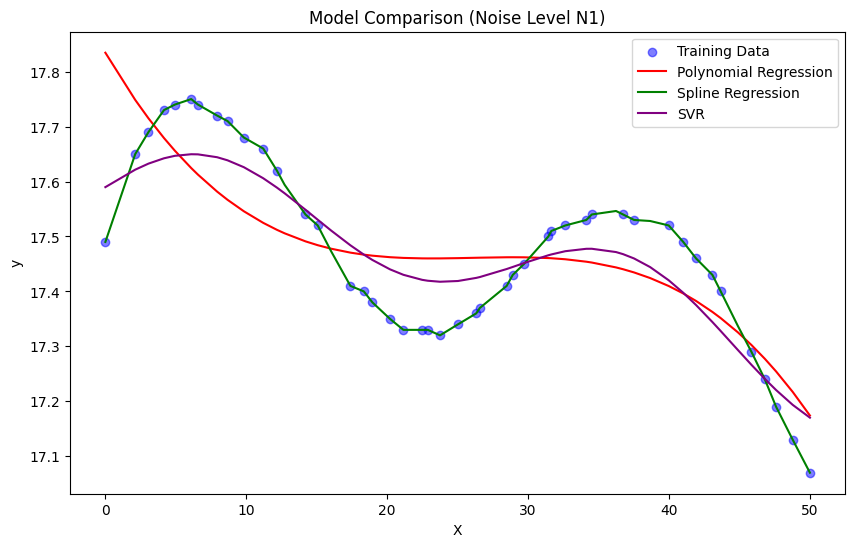

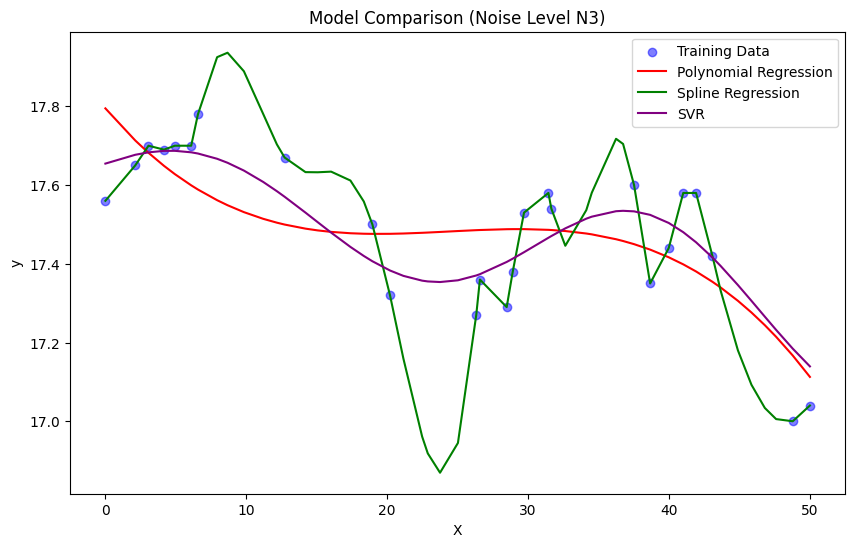

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.interpolate import UnivariateSpline
from sklearn.svm import SVR
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define file names and path
TRUE = 'DS-5-1-GAP-0-1-N-0_v2.csv'
NOISE1 = 'DS-5-1-GAP-1-1-N-1_v2.csv'
NOISE2 = 'DS-5-1-GAP-5-1-N-3_v2.csv'

# Define path to data
data_path = '/content/drive/My Drive/'

# Load datasets
d_true = pd.read_csv(data_path + TRUE, header=None)
d_noise1 = pd.read_csv(data_path + NOISE1, header=None)
d_noise2 = pd.read_csv(data_path + NOISE2, header=None)

# Prepare the datasets function
def prepare_data(df):
    X = df.iloc[:, 0].values.reshape(-1, 1)  # Time column
    y = df.iloc[:, 1:101].values  # First 100 data columns (A1 to A100)
    return X, y

X_test, y_test = prepare_data(d_true)
X_train_n1, y_train_n1 = prepare_data(d_noise1)
X_train_n3, y_train_n3 = prepare_data(d_noise2)

# Regression models
def fit_polynomial(X, y, degree=3):
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)
    return model, poly

def fit_spline(X, y, s=0):
    return UnivariateSpline(X.flatten(), y, s=s)

def fit_kernel_svr(X, y, kernel='rbf', C=1.0, epsilon=0.1):
    model = SVR(kernel=kernel, C=C, epsilon=epsilon)
    model.fit(X, y)
    return model

# Compute bias and variance
def compute_bias_variance(y_true, y_preds):
    bias = np.mean(y_true - np.mean(y_preds, axis=1))
    variance = np.mean(np.var(y_preds, axis=1))
    return bias, variance

# Perform regressions on 100 curves (A1 to A100)
def perform_regressions(X_train, y_train, X_test, y_true, level):
    results = []
    n_curves = y_train.shape[1]  # Number of curves (100 in this case)
    y_preds_test = []

    curve_for_plot = np.random.randint(0, n_curves)

    for i in range(n_curves):
        y_train_single = y_train[:, i]

        # Polynomial Regression
        model_poly, poly = fit_polynomial(X_train, y_train_single, degree=3)
        y_pred_test_poly = model_poly.predict(poly.transform(X_test))

        # Spline Regression
        model_spline = fit_spline(X_train, y_train_single)
        y_pred_test_spline = model_spline(X_test.flatten())

        # Support Vector Regression (SVR)
        model_svr = fit_kernel_svr(X_train, y_train_single)
        y_pred_test_svr = model_svr.predict(X_test)

        # Collect all predictions (for bias/variance calculation later)
        y_preds_test.append((y_pred_test_poly, y_pred_test_spline, y_pred_test_svr))

        # Store predictions for plotting only the selected curve
        if i == curve_for_plot:
            plot_data = {
                'X_train': X_train,
                'y_train_single': y_train_single,
                'y_pred_poly': y_pred_test_poly,
                'y_pred_spline': y_pred_test_spline,
                'y_pred_svr': y_pred_test_svr
            }

    # Reshape predictions
    y_preds_poly, y_preds_spline, y_preds_svr = np.array([pred[0] for pred in y_preds_test]).T, \
                                                np.array([pred[1] for pred in y_preds_test]).T, \
                                                np.array([pred[2] for pred in y_preds_test]).T

    # Calculate bias and variance for each model
    for model_name, y_preds in zip(['Polynomial', 'Spline', 'SVR'],
                                   [y_preds_poly, y_preds_spline, y_preds_svr]):
        bias, variance = compute_bias_variance(y_true[:, 0], y_preds)
        results.append({'Model': model_name, 'Level': level, 'Bias': bias, 'Variance': variance})

    return results, plot_data

# Perform regressions and compute results for both noise levels
results_n1, plot_data_n1 = perform_regressions(X_train_n1, y_train_n1, X_test, y_test, 'N1')
results_n3, plot_data_n3 = perform_regressions(X_train_n3, y_train_n3, X_test, y_test, 'N3')

# Combine results and create DataFrame for comparison
results = results_n1 + results_n3
df_results = pd.DataFrame(results)
print(df_results)

# Plotting the selected curve for Noise Level N1
plt.figure(figsize=(10, 6))
plt.scatter(plot_data_n1['X_train'], plot_data_n1['y_train_single'], color='blue', label='Training Data', alpha=0.5)
plt.plot(X_test, plot_data_n1['y_pred_poly'], label='Polynomial Regression', color='red')
plt.plot(X_test, plot_data_n1['y_pred_spline'], label='Spline Regression', color='green')
plt.plot(X_test, plot_data_n1['y_pred_svr'], label='SVR', color='purple')
plt.title('Model Comparison (Noise Level N1)')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

# Plotting the selected curve for Noise Level N3
plt.figure(figsize=(10, 6))
plt.scatter(plot_data_n3['X_train'], plot_data_n3['y_train_single'], color='blue', label='Training Data', alpha=0.5)
plt.plot(X_test, plot_data_n3['y_pred_poly'], label='Polynomial Regression', color='red')
plt.plot(X_test, plot_data_n3['y_pred_spline'], label='Spline Regression', color='green')
plt.plot(X_test, plot_data_n3['y_pred_svr'], label='SVR', color='purple')
plt.title('Model Comparison (Noise Level N3)')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()



# Conclusion

The findings of this study support the hypothesis that excessive social media use negatively affects the academic performance of college students. The significant negative correlation between time spent on social media and grades suggests that students who spend more time on social media tend to have lower grades. These findings highlight the importance of developing strategies to help students balance social media use with their academic responsibilities. Future research could explore the specific mechanisms underlying this relationship and investigate the effectiveness of interventions aimed at reducing the negative impact of social media on academic performance.